# AR(1)プロセスの理解と平均の分散


このノートでは図はipynb内に表示し、画像ファイルとしては保存しません。

このノートでは、AR(1)プロセスの基本式と平均の分散を整理し、シミュレーションで確認します。
**第8章のMCMC（メトロポリス・ヘイスティングス法）** との記号の整合性をとるため、自己回帰係数を $\phi$ と表記します。

- **AR(1)プロセス**: $ y_t = \phi y_{t-1} + \varepsilon_t $, $ \varepsilon_t \sim N(0,\sigma^2) $
  - **定常 ($|\phi| < 1$)**: 平均へ回帰する。
  - **ランダムウォーク ($|\phi| = 1$)**: 非定常。分散が時間とともに増大する（第8章で提案分布として利用）。
- **定常分散 ($|\phi| < 1$)**: $ \sigma_u^2 = \dfrac{\sigma^2}{1-\phi^2} $
- **平均の分散**: 


まず平均を

$$
\bar{y}_T = 
\frac{1}{T}\sum_{t=1}^T y_t
$$

と置くと、自己共分散 $\gamma_h=\mathrm{Cov}(y_t,y_{t-h})$ を用いて

$$
\mathrm{Var}(\bar{y}_T)=
\frac{1}{T^2}\sum_{t=1}^T\sum_{s=1}^T\gamma_{|t-s|}
$$

となります。AR(1)では

$$
\gamma_h=\sigma_u^2\phi^{|h|}
$$

なので、二重和を整理すると

$$
\mathrm{Var}(\bar{y}_T)=
\frac{1}{T^2}\Big(T\gamma_0 + 2\sum_{h=1}^{T-1}(T-h)\gamma_h\Big)
$$

$$
=
\frac{1}{T^2}\Big(T\sigma_u^2 + 2\sum_{h=1}^{T-1}(T-h)\sigma_u^2\phi^h\Big)
$$

となり、本文の式を得ます。

同じ分散 $\sigma_u^2$ を持つ **iidサンプル** $ x_i \sim N(\mu, \sigma_u^2) $ の平均の分散は

$$
\mathrm{Var}(\bar{x}_T)=
\frac{\sigma_u^2}{T}
$$

であり、相関があると$\mathrm{Var}(\bar{y}_T)$ が増えることを確認します。

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

np.random.seed(42)


In [2]:
def simulate_ar1(phi, sigma, T, n_simulations=1):
    """AR(1)をシミュレーションする。"""
    y = np.zeros((n_simulations, T))
    epsilon = np.random.normal(0, sigma, (n_simulations, T))

    if abs(phi) < 1:
        stationary_variance = sigma**2 / (1 - phi**2)
        y[:, 0] = np.random.normal(0, np.sqrt(stationary_variance), n_simulations)
    else:
        y[:, 0] = epsilon[:, 0]

    for t in range(1, T):
        y[:, t] = phi * y[:, t - 1] + epsilon[:, t]

    return y


def theoretical_variance_of_sample_mean(phi, sigma, T):
    """AR(1)の標本平均の理論分散を計算する。"""
    if abs(phi) >= 1:
        return np.inf

    gamma_0 = sigma**2 / (1 - phi**2)
    h = np.arange(1, T)
    sum_term = np.sum((T - h) * (phi ** h))
    variance = (gamma_0 / T**2) * (T + 2 * sum_term)
    return variance


def autocorrelation(x):
    """単純な自己相関推定。"""
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    r = np.correlate(x, x, mode="full")[-n:]
    return r / (variance * np.arange(n, 0, -1))


## シミュレーションで平均の分散を確認


In [3]:
phi = 0.5
sigma = 1.0
T = 100
n_simulations = 10000

simulated_data = simulate_ar1(phi, sigma, T, n_simulations)
sample_means = np.mean(simulated_data, axis=1)
empirical_variance = np.var(sample_means, ddof=1)

theoretical_var = theoretical_variance_of_sample_mean(phi, sigma, T)
iid_variance = (sigma**2 / (1 - phi**2)) / T

print(f"理論分散: {theoretical_var:.6f}")
print(f"経験分散: {empirical_variance:.6f}")
print(f"比較用のiid分散: {iid_variance:.6f}")
print(f"比 (AR(1) / iid): {theoretical_var / iid_variance:.4f}")


理論分散: 0.039467
経験分散: 0.040007
比較用のiid分散: 0.013333
比 (AR(1) / iid): 2.9600


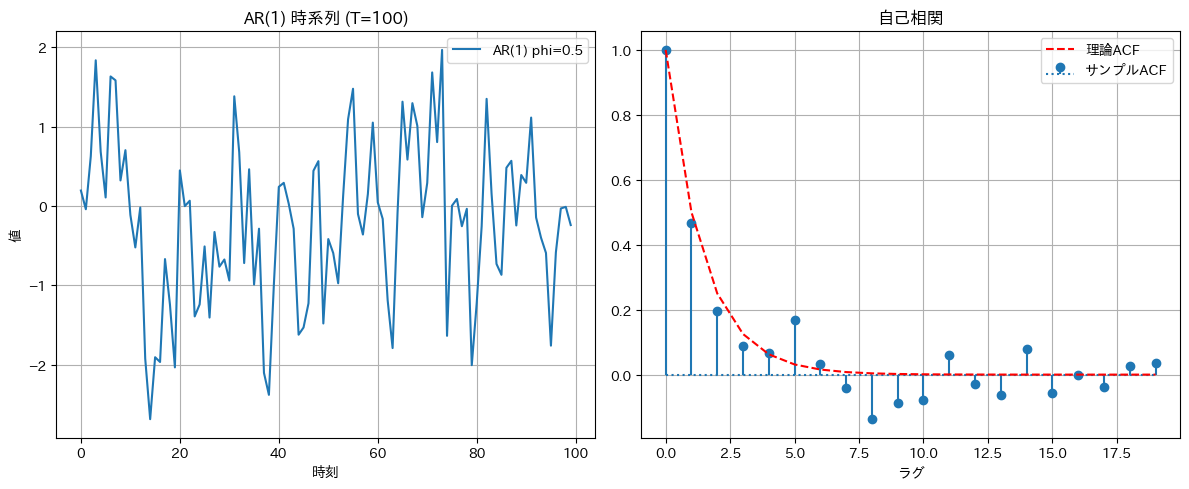

In [4]:
y_single = simulated_data[0]
acf = autocorrelation(y_single)
lags = 20

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_single, label=f"AR(1) phi={phi}")
plt.title(f"AR(1) 時系列 (T={T})")
plt.xlabel("時刻")
plt.ylabel("値")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.stem(range(lags), acf[:lags], basefmt=":", label="サンプルACF")
plt.plot(range(lags), phi ** np.arange(lags), "r--", label="理論ACF")
plt.title("自己相関")
plt.xlabel("ラグ")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 相関行列のイメージ

$ \mathrm{Cov}(y_i, y_j) = \sigma_u^2\phi^{|i-j|} $ なので、対角から離れるほど値が減衰します。


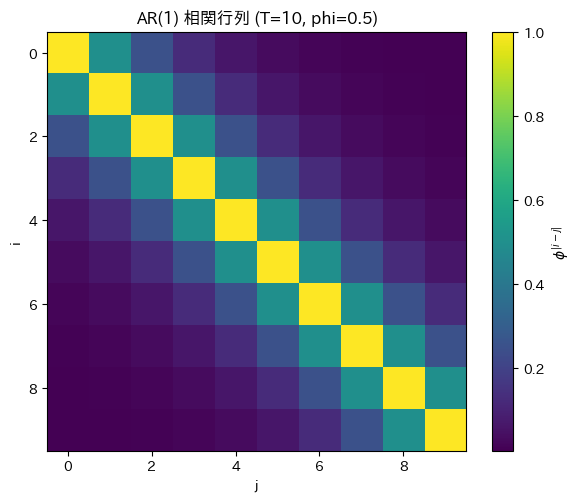

In [5]:
T_matrix = 10
phi_matrix = 0.5

indices = np.indices((T_matrix, T_matrix))
correlation_matrix = phi_matrix ** np.abs(indices[0] - indices[1])

plt.figure(figsize=(6, 5))
img = plt.imshow(correlation_matrix, cmap="viridis")
plt.colorbar(img, label=r"$\phi^{|i-j|}$")
plt.title(f"AR(1) 相関行列 (T={T_matrix}, phi={phi_matrix})")
plt.xlabel("j")
plt.ylabel("i")
plt.xticks(np.arange(0, T_matrix, 2))
plt.yticks(np.arange(0, T_matrix, 2))
plt.tight_layout()
plt.show()


## 相関による精度の低下（平均の分散比）

同じ分散 $\sigma_u^2$ を持つ iid サンプル平均との差を比較します。


/tmp/ipykernel_955150/2408548367.py:24: UserWarning: Glyph 563 (\N{LATIN SMALL LETTER Y WITH MACRON}) missing from font(s) IPAexGothic.
  plt.tight_layout()
/home/user/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 563 (\N{LATIN SMALL LETTER Y WITH MACRON}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


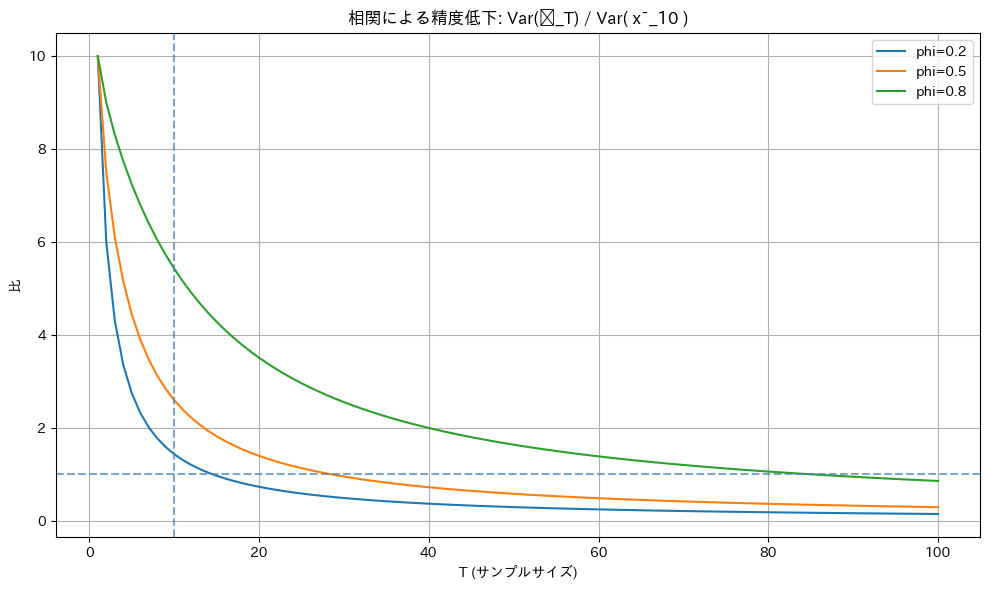

In [6]:
phis = [0.2, 0.5, 0.8]
T_max = 100
T_range = np.arange(1, T_max + 1)

plt.figure(figsize=(10, 6))

for phi_val in phis:
    h_vals = np.arange(1, T_max).reshape(-1, 1)
    t_vals = T_range.reshape(1, -1)
    t_minus_h = t_vals - h_vals
    mask = h_vals < t_vals
    sum_terms = np.sum(t_minus_h * (phi_val ** h_vals) * mask, axis=0)
    var_terms = T_range + 2 * sum_terms
    ratios = (var_terms / (T_range**2)) / (1.0 / 10.0)
    plt.plot(T_range, ratios, label=f"phi={phi_val}")

plt.axhline(y=1.0, color="steelblue", linestyle="--", alpha=0.7)
plt.axvline(x=10.0, color="steelblue", linestyle="--", alpha=0.7)
plt.title("相関による精度低下: Var(ȳ_T) / Var( x̄_10 )")
plt.xlabel("T (サンプルサイズ)")
plt.ylabel("比")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## AR(1) とランダムウォークの比較（「酔歩」の可視化）

第8章の「酔歩連鎖（MCMC）」で使われるランダムウォーク（$\phi=1$）と、定常AR(1)（$\phi=0.5$）の挙動の違いを可視化します。
ランダムウォークは分散が時間とともに拡大し、どこまでも「ふらふらと」移動していく様子（イカの足のように広がる様子）が確認できます。


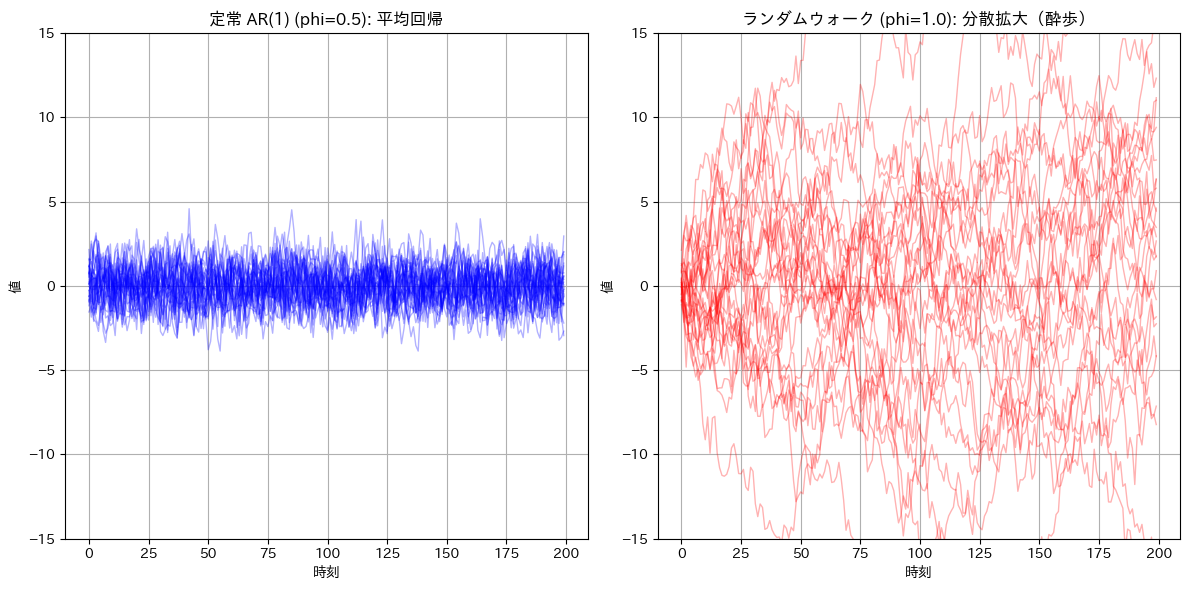

In [7]:
T_rw = 200
n_paths = 30
phi_stationary = 0.5
phi_rw = 1.0

# 複数のパスを生成
paths_stationary = simulate_ar1(phi_stationary, sigma, T_rw, n_paths)
paths_rw = simulate_ar1(phi_rw, sigma, T_rw, n_paths)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(paths_stationary[i], color="blue", alpha=0.3, linewidth=1)
plt.title(f"定常 AR(1) (phi={phi_stationary}): 平均回帰")
plt.xlabel("時刻")
plt.ylabel("値")
plt.ylim(-15, 15)
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(n_paths):
    plt.plot(paths_rw[i], color="red", alpha=0.3, linewidth=1)
plt.title(f"ランダムウォーク (phi={phi_rw}): 分散拡大（酔歩）")
plt.xlabel("時刻")
plt.ylabel("値")
plt.ylim(-15, 15)
plt.grid(True)

plt.tight_layout()
plt.show()


## 補足: $x_i$ は比較用の仮想データ

$ x_i $ は $ y_t $ から生成されるわけではなく、**同じ分散を持つ独立サンプル**という比較用の基準線です。


## (参考) ランダムウォークを用いたMCMC：メトロポリス法

第8章の冒頭（）で扱っているMCMC（メトロポリス・ヘイスティングス法）では、この「ランダムウォーク」を提案分布として利用します。
ランダムウォーク（$\phi=1$）は分散が拡大し続けるため、空間全体を探索する能力があります。MCMCでは、この「探索能力」を利用しつつ、目標分布 $\pi(x)$ の確率密度比に基づく「採択/棄却」のステップを入れることで、目標分布からのサンプリングを実現します。

以下は、標準正規分布 (0, 1)$ を目標分布とし、ランダムウォークを提案分布としたメトロポリス法の簡易シミュレーションです。

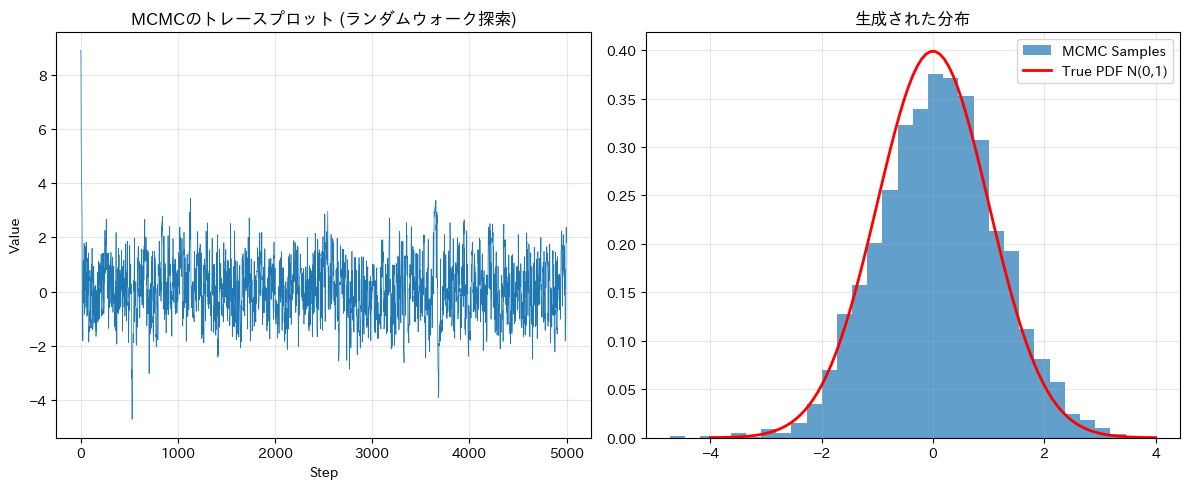

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 目標分布: 標準正規分布
def target_pdf(x):
    return norm.pdf(x, loc=0, scale=1)

# ランダムウォーク・メトロポリス法
np.random.seed(123)
n_iter = 5000
current_x = 10.0  # 初期値（あえて分布の裾からスタート）
samples = []
trace = []

# ステップ幅（ランダムウォークの分散）
step_width = 1.0

for i in range(n_iter):
    # 1. 提案: ランダムウォーク (現在の値 + ノイズ)
    # x' = x + epsilon, epsilon ~ N(0, step_width^2)
    # これが phi=1 の AR(1) の1ステップに相当
    proposal_x = current_x + np.random.normal(0, step_width)
    
    # 2. 採択確率の計算
    # 提案分布が対称(正規分布)なので、目標分布の比だけで決まる
    ratio = target_pdf(proposal_x) / target_pdf(current_x)
    acceptance_prob = min(1.0, ratio)
    
    # 3. 採択/棄却
    if np.random.rand() < acceptance_prob:
        current_x = proposal_x  # 採択（移動）
    else:
        pass  # 棄却（現在地に留まる）
    
    trace.append(current_x)
    if i > 100: # バーンイン
        samples.append(current_x)

# 可視化
plt.figure(figsize=(12, 5))

# トレースプロット
plt.subplot(1, 2, 1)
plt.plot(trace, lw=0.5)
plt.title("MCMCのトレースプロット (ランダムウォーク探索)")
plt.xlabel("Step")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

# ヒストグラム
plt.subplot(1, 2, 2)
plt.hist(samples, bins=30, density=True, alpha=0.7, label="MCMC Samples")
x = np.linspace(-4, 4, 100)
plt.plot(x, target_pdf(x), 'r-', lw=2, label="True PDF N(0,1)")
plt.title("生成された分布")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# コラム：ARIMAモデルとは

*(夜間、街の明かりに照らされた近代的な都市で、オンライン設備を見ている若いビジネスウーマン)*

### 共同執筆者
**Joshua Noble** (Data Scientist)

## ARIMAモデルの概要
ARIMAは自己回帰和分移動平均（AutoRegressive Integrated Moving Average）の略称で、時系列分析および時系列で将来生じ得る値を予測するための手法です。

自己回帰モデリングと移動平均モデリングは、時系列データを予測するための2つの異なるアプローチです。ARIMAはこれら2つのアプローチを統合しているため、この名前が付けられています。予測は、時系列の過去の動作を使用して、その時系列の1つ以上の将来の値を予測する機械学習の一分野です。小さな店でアイスクリームを買うことを想像してみてください。天候の温暖化に伴い、アイスクリームの売上が着実に増加していることをご存じであれば、おそらく来週の注文は、この数週間の注文よりも少し増えるはずだと予測できるでしょう。どの程度大きくなるかは、今週の売上が前週の売上とどれだけ異なるかによって決まります。比較する過去がなければ未来を予測することはできないため、過去の時系列データはARIMAばかりではなく、すべての予測手法や時系列分析手法にとって非常に重要です。

ARIMA は、時系列予測に最も広く使用されているアプローチの1つであり、作業する時系列データのタイプに応じて異なる2つの方法で使用できます。最初のケースでは、時系列データの季節性を考慮する必要のない非季節性ARIMAモデルを作成しました。過去のデータのパターンに基づいて未来を予測します。2番目のケースでは、時系列に影響する規則的なサイクルである季節性を考慮しています。これらのサイクルは日次、週次、月次のいずれかに指定でき、将来の値を予測するために使用できる時系列の過去データのパターンを定義するのに役立ちます。データサイエンスの多くと同様に、予測の基礎となるのは、モデルをトレーニングするための優れた時系列データを持つことです。時系列は、変数を等間隔で測定する順序付けされた一連の値です。この等間隔の時間間隔要件のため、時間要素を含むすべてのデータセットが実際には時系列データであるとは限らないことを覚えておくことが重要です。

## ボックス・ジェンキンス法
1970年、統計学者のジョージ・ボックスとグウィリム・ジェンキンスは、あらゆる種類の時系列モデルを適合させるために、ボックス・ジェンキンス法として知られるようになった方法を提案しました。このアプローチは、時系列を生成したプロセスが定常である場合、モデルを使用して近似できるという仮定から始まります。これは、次の4つのステップで構成されています。

1. **識別**：時系列が定常であるかどうかを評価し、定常でない場合は、定常とするために必要な差分の数を評価します。次に、診断プロットで使用する差分データを生成します。自己相関および部分自己相関からデータのARMAモデルのパラメーターを特定します。
2. **推定**：データを使ってモデルのパラメーター（係数）をトレーニングします。
3. **診断チェック**：利用可能なデータとの関連で適合モデルを評価し、モデルが改善される可能性のある領域をチェックします。特に、過剰適合のチェックや残差の計算が含まれます。
4. **予測**：モデルができたら、そのモデルを使用して値の予測を開始できます。

モデルがデータに正しく適合していることを確認したら、ARIMAによる予測を開始する準備が整います。これらの各ステップを詳しく見ていきます。

## 時系列データの特徴
時系列は定常時系列か非定常時系列のいずれの場合もあります。定常時系列には、時間の経過とともに一定の統計的特性があります。つまり、平均、分散、自己相関などの統計は、データによって変化しないという意味です。ARIMAなどのほとんどの統計的予測手法は、時系列が1つ以上の変換を通じてほぼ定常にできるという仮定に基づいています。定常時系列は、統計的性質が将来も過去とほぼ同じであることを単純に予測できるため、予測が比較的容易です。非固定データの操作は可能ですが、ARIMAのようなアプローチでは困難です。

時系列データの別の主な特徴は、データにトレンドが存在するかどうかです。例えば、過去50年間に食料品店で販売されていた基本食料品の価格は、インフレによって価格が上昇するため、トレンドを示すことになります。トレンドを含むデータの予測は、トレンドによってデータ内の他のパターンが不明瞭になるため、難しい場合があります。データに安定したトレンド・ラインがあり、それが一貫して回帰する場合、それはトレンド定常である可能性があります。この場合、モデルを当てはめる前に、トレンド・ラインを当てはめ、データからトレンドを差し引くだけで、トレンドを取り除くことができます。データがトレンド定常でない場合は、差分定常である可能性があり、その場合は差分化によってトレンドを取り除くことができます。差分化を行う最も簡単な方法は、各値から前の値を引いて、時系列データにどれだけの変化があるかを測定することです。例えば、$Y_t$が期間$t$における時系列Yの値である場合、期間$t$におけるYの最初の差は$Y_t - Y_{t-1}$に等しくなります。

こちらは、非定常時系列のプロットです。それは明らかな上昇傾向があり、季節性を示しています。

*(徐々に増加する時系列を示す時系列グラフ)*

ここでの季節性は、通常の12か月サイクルです。これは、時系列を12単位ずつ差分して対処すると1990年4月と1989年4月を区別できます。12単位の遅延を伴う差分を時系列に適用すると、より定常な時系列が得られます。この時系列の差異はまだ変化していますが、ARIMAモデルはこの時系列に適合し、それを使用した予測を行うことができます。

*(前のデータを差分で示し、増加傾向を除外した時系列グラフ)*

例えば、周期的な振る舞いはあるがトレンドや季節性のない時系列も定常的です。系列を観察する際にサイクルの長さが一定でない限り、サイクルのピークと谷がどこで発生するのかを知ることはできません。一般に、定常的な時系列には、長期的には予測可能なパターンはありません。時系列データを折れ線グラフにプロットすると、一定の分散があり、大きなスパイクや減少がないため、ほぼ水平方向に見えます。

## 自己相関
自己相関を計算することで、時系列が過去の値とどの程度相関しているかを知ることができます。自己相関を計算することで、データがランダム性を示しているかどうか、ある観測値がすぐ隣の観測値とどの程度関連しているかについての質問に答えることができます。これにより、どのようなモデルがデータを最もよく表しているかがわかります。自己相関は、ラグ単位までの点間の相関関係を確認するためにプロットされることがよくあります。

自己相関における各ラグ$k$は、次のように定義されます。

$$
r_k = \frac{\sum_{t=k+1}^T (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^T (y_t - \bar{y})^2}
$$

$r$は自己相関の遅れ、$T$は時系列の長さ、$y$は時系列の値を表します。自己相関係数は自己相関関数（ACF）を構成します。

ACFでは、相関係数はx軸にあり、遅れの数（遅れ順序と呼ばれる）はy軸に示されます。自己相関プロットは、statsmodelsライブラリーの`plot_acf`を使用してPythonで作成でき、`acf`関数を使用してRで作成できます。

*(自己相関関数のプロット)*

このACFプロットでは、12の時間単位のラグで差分された時系列のラグは、ゼロラグ自体と完全に相関しています。最初のラグは負、2番目のラグはわずかに正、3番目のラグは負のようになります。12番目のラグはそれ自体と強く相関していることに気付くでしょう。月次データを見ていたので、これは理にかなっています。自己相関は時系列全体でほぼ同じサイクルを維持しており、時系列にはまだ大きな季節性が含まれていることを示しています。ACFプロットは、このデータに最も適合するARIMAモデルのパラメーターを推測するのにも役立ちます。



### 自己相関の直感的理解
想像してみてください。ある日の売上や気温、株価などの時系列データがあるとします。「今日の売上」と「昨日の売上」は似たような傾向があるかもしれません。もっと前の「1週間前の売上」も、何らかの関係を持っているかもしれません。自己相関とは、この「時刻差（ラグ：lag）＝k」のときに、いまの値と1つ前、2つ前……というずらし方での相関を数値で表したものです。

自己相関を調べると、「データがどのくらい過去の値に影響されているか」が見えます。
- 時系列がランダムすぎて自己相関がほとんどない場合：過去の値から未来を予測しづらい
- 自己相関が強く残っている場合：少し前のデータから未来を予想できそう
といった判断に使えます。

## 部分自己相関関数（PACF）
時系列データにARIMAモデルを使用する準備におけるもう1つの重要なプロットは、部分自己相関関数です。ACFプロットは、$y_t$と$y_{t-k}$の間の関係を、$k$のさまざまな値について示します。$y_t$と$y_{t-1}$が相関している場合、$y_{t-1}$と$y_{t-2}$も相関します。しかし、$y_{t-2}$に含まれる新しい情報が$y_t$の予測に使われるのではなく、むしろ$y_{t-1}$と$y_{t-2}$の両方が関連しているために、$y_t$と$y_{t-2}$が相関している可能性もあります。この問題を克服するためには、偏自己相関を使用して、多くのラグ観測値を取り除くことができます。これらは、ラグ1から$k$の影響を取り除いた後の$y_t$と$y_{t-k}$の関係を測定します。それで、最初の偏自己相関は最初の自己相関と同じです。それは、除去すべき何かがないからです。各部分的な自己相関は、自己回帰モデルの最後の係数として推定できます。

RやPython、その他のプログラミング言語やライブラリーで作業していても、PACFを計算し、簡単に検査できるPACFプロットを作成する方法があります。自己相関プロットは、pythonではstatsmodelsライブラリーの`plot_pacf`を使って作成でき、Rでは`pacf`関数を使って作成できます。

*(偏自己相関関数のプロット)*

このPACFは、上記のACFプロットと同じデータを使用しています。PACFプロットは、ACFプロットのように0ではなく1から始まり、前年の同じ月と相関する1.0の遅れまで強い相関を示します。その最初の1年を過ぎると、ラグの数が増えるにつれて自己相関の量が減少していきます。年ごとに変動する月次データを見ていたので、これは理にかなっています。



### 偏自己相関の「偏」とは？
偏自己相関は、自己相関のうち、間にある他の時点の影響を取り除いたうえで、どれくらい相関があるかを見るものです。
たとえば lag=3 の自己相関を見るとき、直接「3つ前のデータ」と現在のデータを比べていますが、そこには「1つ前」「2つ前」のデータの影響も含まれているかもしれません。偏自己相関は、その中間にある影響（ラグ1・ラグ2の影響）をいったん取り除いたうえで、本当に「3つ前のデータ」と「現在のデータ」だけの純粋な相関を測ります。

### ARモデルとMAモデルの見分け方
ACFとPACFのプロットの形状は、ARIMAモデルの次数（p, q）を決定する重要な手がかりになります。

- **AR(p) モデル（自己回帰モデル）の場合**:
    - **PACF**がラグ $p$ までは有意で、ラグ $p+1$ 以降は突然ゼロ付近になります（カットオフ）。
    - ACFは徐々に減衰します。
- **MA(q) モデル（移動平均モデル）の場合**:
    - **ACF**がラグ $q$ までは有意で、ラグ $q+1$ 以降は突然ゼロ付近になります（カットオフ）。
    - PACFは徐々に減衰します。

つまり、ACFとPACFのどちらが「スパッと切れる（カットオフする）」かを見比べることで、ARモデルかMAモデルかの当たりをつけることができます。

### 観点の棚卸し（AR/MA/ARIMAの識別）

| モデル | 観点1: 自己相関 (ACF) | 観点2: 偏自己相関 (PACF) |
|---|---|---|
| **AR(p) 自己回帰** | 徐々に減衰 (Tail off) | **ラグpで切断 (Cut off)** |
| **MA(q) 移動平均** | **ラグqで切断 (Cut off)** | 徐々に減衰 (Tail off) |
| **ARMA / ARIMA** | 徐々に減衰 | 徐々に減衰 |


## 自己回帰と移動平均
その名前が示すように、ARIMAという頭字語では、渡されたパラメーターに応じて、自己回帰モデルと移動平均モデルを単一のモデルに統合します。時系列全体を通じて変化をモデリングするこれら2つの方法は関連していますが、いくつかの大きな違いがあります。自己回帰モデルでは、変数の過去値の線形結合を使用して予測します。自己回帰という用語は、変数自体に対する回帰であることを示します。この手法は、過去の値を回帰のインプットとして使用する方法が線形回帰モデルと似ています。自己回帰は次のように定義されます。

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \varepsilon_t
$$

ここでは、$\varepsilon_t$はホワイトノイズです。これは重回帰に似ていますが、予測変数として$y_t$の遅延値を使用します。これをAR(p)モデル、つまりp次の自己回帰モデルと呼びます。

一方、移動平均モデルは、回帰で予測変数の過去の値を使用するのではなく、過去の予測誤差を使用します。移動平均は、ウィンドウ内の$k$個の値を単純に平均化し、ここで、$k$は移動平均ウィンドウのサイズであり、このウィンドウを進めます。予測値は実際の値を使用して評価され、時系列の各ステップにおける誤差が特定されます。移動平均は次のように定義されます。

$$
y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \dots + \theta_q \varepsilon_{t-q}
$$

$\varepsilon_t$ はホワイトノイズです。これをMA(q)モデル、つまりq次の移動平均モデルと呼びます。もちろん、 $\varepsilon_t$の値は観測しないので、通常の意味での回帰ではありません。$y_t$の各値は、過去いくつかの予測誤差の重み付けされた移動平均と考えることができることに注意してください。

通常、ARIMAモデルでは、自己回帰項（AR）項または移動平均項（MA）のいずれかを使用します。ACFプロットとPACFプロットは、これらの用語のうちどれが最も適切かを判断するためによく使用されます。

## ARIMAモデルの指定
時系列を定常化し、自己相関の性質が判別されると、ARIMAモデルを適合させることが可能になります。ARIMAモデルには、通常、$p$、$d$、$q$と呼ばれる3つの主要なパラメーターがあります。

- **p**：ARIMAの自己回帰部分の次数
- **d**：関係する差分の程度
- **q**：移動平均部分の次数

これらは通常、ARIMA(p, d, q)の順序で書かれます。多くのプログラミング言語やパッケージは、分析する時系列とこれら3つのパラメータを使用して呼び出すことができるARIMA関数を提供しています。ほとんどの場合、データはトレーニング・セットとテスト・セットに分割され、トレーニング後にモデルの精度をテストできます。通常、時間プロットを見だけで、データに最も適切なpとqの値を知ることはできません。ただし、ACFおよびPACFプロットを使用してpとqの適切な値を決定できることが多いため、これらのプロットはARIMAを扱う上で重要な用語です。

モデルでAR用語を使用する大まかな基準は次のとおりです。

- ACFプロットは自己相関がゼロに向かって減少していることを示す
- PACFプロットはゼロに向かって急速に途切れる
- 定常系列のACFはLag - 1で正を示す

モデルでMAの用語を使用する状況のおおよその基準は、次の場合です。

- ラグ-1で負に自己相関
- 数回の遅れで急激に低下するACF
- PACFが突然ではなく徐々に減少

遭遇する可能性のある従来のARIMAモデル・タイプがいくつかあります。

- **ARIMA (1,0,0) = 1次自己回帰モデル**: 系列が定常で自己相関関係にある場合、おそらくそれ自体の以前の値の倍数に定数を加えたものとして予測できます。今日からのアイスクリームの売上だけを使って明日のアイスクリームの売上を直接予測できるとしたら、それは一次自己回帰モデルです。
- **ARIMA(0,1,0) = ランダム・ウォーク**: 時系列が定常でない場合、最も単純なモデルはランダム・ウォーク・モデルです。ランダム・ウォークは、シーケンス内の次の値がシーケンス内の前の値の修正であるため、乱数のリストとは異なります。これは、よくある、株価の差異値のモデル化方法です。
- **ARIMA(1,1,0) = 差分一次自己回帰モデル**: ランダム・ウォーク・モデルのエラーが自己相関している場合、予測方程式に従属変数の1つのラグを追加することで、つまり、Yの最初の差分を1期間ラグしたそれ自体に回帰することで、問題を解決できる可能性があります。
- **定数なしのARIMA(0,1,1) = 単純な指数平滑化モデル**: これは、季節性やトレンドのない時系列データに使用されます。過去の観測からの影響度（0～1の間の係数値で示される）を制御する単一の平滑化パラメーターが必要です。この手法では、1に近い値はモデルが過去の観測値にほとんど注意を払うことを意味し、小さい値は予測中により多くの履歴を考慮することを意味します。
- **定数付きARIMA(0,1,1) = 単純な指数平滑化成長モデル**: これは、単純な指数平滑化と同じですが、時系列のY値が進行するにつれて増大する付加的な定数項がある点が異なります。

もちろん、ARIMAモデルを適合させる方法は他にもたくさんあります。そのため、複数のモデルを計算し、比較して、どのモデルがデータに最もよく適合するかを確認することがよくあります。これらはすべて一次モデルであり、線形プロセスをマッピングすることを意味します。二次プロセスをマッピングする2次モデルと、より複雑なプロセスをマッピングする上位モデルがあります。

## ARIMAモデルの比較
通常、複数のARIMAモデルをデータに適合させ、相互に比較することで、どの資産が時系列データに見られるパターンを予測しているかを見つけられます。ARIMAモデルの精度を評価するための重要な指標は次の3つです。

1. **Akaikeの情報基準またはAIC**。これは、回帰モデルの予測子の選択に広く使用されており、ARIMAモデルの次数の決定にも役立ちます。AICは、モデルの適合性とモデルの単純さないし倹約性の両方を単一の統計情報で定量化します。AICスコアが低いほど良いため、スコアが低いモデルを好みます。AICはより単純なモデルを優先し、より複雑なモデルは、その精度がより単純なモデルとほぼ同じである限り、より高いスコアを獲得します。また、単にサンプル・サイズに小さな修正を加えた修正済みAICやAICCもあります。
2. **ベイズ情報基準（BIC）**。これは、AICよりも多くの複雑さにペナルティーを与えるモデル選択のもう1つの基準です。AICと同様に、BICの低いモデルは、一般的にスコアの高いモデルよりも優先されます。モデルが長期予測に使用される場合は、BICの方が適している可能性がありますが、短期予測にはAICの方が適しているということかもしれません。
3. **シグマ二乗またはsigma2値**は、モデル残差の分散です。シグマは、仮想プロセスの不安定性を表します。揮発性が高いデータにもかかわらずシグマ二乗スコアが非常に低い場合や、逆に非揮発性データであるがシグマ二乗スコアが高い場合は、モデルが実際のデータ生成プロセスをうまく捉えていないことを示しています。

テスト・データ・セットを留保した場合は、異なる予測間隔のRMSEなどの精度メトリクスを比較することもできます。ARIMAモデルは、将来の単一の時間ステップまたは一度に複数のステップの値を予測できます。

## ARIMAのバリエーション
ARIMAモデルの構成と比較に対するもう1つのアプローチは、自動化された構成タスクをARIMAモデルの生成と比較に適用するAuto-ARIMAを使用することです。最適なモデルを得るには、複数の方法があります。アルゴリズムは複数のモデルを生成し、AICcと最尤推定の誤差を最小化してARIMAモデルを得ようとします。

**季節性自己回帰統合移動平均、SARIMAまたは季節性ARIMA**は、季節的要素を含む時系列データをサポートするARIMAの拡張版です。そのために、系列の季節成分の自己回帰、差分、移動平均を指定する3つの新しいハイパーパラメーターと、季節性の期間のパラメーターを追加します。SARIMAモデルは通常、SARIMA((p,d,q),(P,D,Q))と表現され、小文字は時系列の非季節性成分を示し、大文字は季節性成分を示します。

**ベクトル自己回帰モデル（またはVARモデル）**は、多変量の時系列に使用されます。これらは、各変数がそれ自体の過去の遅延と他の変数の過去の遅延の線形関数になるように構成されています。

ARIMAモデルは、時系列データを分析して過去のプロセスを理解したり、時系列の将来の値を予測したりするための強力なツールです。ARIMAモデルは、自己回帰モデルと移動平均モデルを組み合わせて、予測者にさまざまな時系列データを使用できる高度にパラメーター化可能なツールを提供します。
